# Sentiment Analysis using BERT

* Dataset used: sentiment140 [Sentiment140](https://www.kaggle.com/datasets/kazanova/sentiment140)
* Documentation used: [sentiment analysis using BERT](https://www.kaggle.com/code/prakharrathi25/sentiment-analysis-using-bert/notebook#Data-Preprocessing)

* Trained using CPU: M1 chip
* Total Time took: 518m, 28.9s

###  Importing Libraries and Setting Up the Environment

In this section, I import all the core libraries required for data processing, visualization, model training, and evaluation.

- **General utilities:**  
  - `sys`, `numpy`, and `pandas` for general-purpose computation and data manipulation.  

- **Visualization:**  
  - `seaborn` and `matplotlib` for data exploration and plotting.  

- **Machine learning utilities:**  
  - `sklearn` for train/test splitting and model evaluation metrics such as confusion matrix and classification report.  
 

- **PyTorch and Transformers:**  
  - `torch` provides the deep learning framework for model training.  
  - `transformers` (by Hugging Face) gives access to pretrained BERT models and tokenizers.  
  - Optimizers like `AdamW` and schedulers like `get_linear_schedule_with_warmup` are used to fine-tune BERT efficiently.  

- **Warnings:**  
  - Minor warnings are suppressed to keep the notebook output clean.

This setup ensures that the notebook is fully prepared for text preprocessing, BERT fine-tuning, and performance evaluation.

In [29]:
import sys
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict
from matplotlib import rcParams
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report


# from google.colab import drive
# drive.mount('/content/drive')


# Torch ML libraries

import transformers
from transformers import BertModel, BertTokenizer, get_linear_schedule_with_warmup

import torch
from torch import nn, optim
from torch.optim import AdamW
from torch.utils.data import Dataset, DataLoader


import warnings
warnings.filterwarnings


<function warnings.filterwarnings(action, message='', category=<class 'Warning'>, module='', lineno=0, append=False)>

###   — Setting Up Visuals, Seeds, and Device

In this section, I configure the notebook for consistent visualizations, reproducible results, and hardware setup.

- **Inline plots for Jupyter:**  
  - `%config InlineBackend.figure_format='retina'` ensures high-resolution plots in the notebook.  

- **Graph design and style:**  
  - `seaborn` styling is set to a clean white grid with a custom color palette for visually appealing plots.  
  - `HAPPY_COLORS_PALETTE` defines vibrant colors for charts, and `rcParams['figure.figsize']` sets the default figure size.  

- **Reproducibility:**  
  - `RANDOM_SEED` ensures that random operations in NumPy and PyTorch produce the same results every time the notebook is run.  

- **Device setup:**  
  - Checks if a GPU is available (`cuda`) for faster training; otherwise, it falls back to CPU.  
  - This allows the BERT model and tensors to run on the best available hardware.

In [3]:
# Set intial variables and constants
%config InlineBackend.figure_format='retina'

# Graph Designs
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8

# Random seed for reproducibilty
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

# Set GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Loading the Dataset

In this step, I load the preprocessed Sentiment140 dataset from Google Drive into a Pandas DataFrame.

- `pd.read_csv()` reads the CSV file containing the tweet data.  
  - `encoding="ISO-8859-1"` ensures proper handling of special characters in tweets.  
  - `engine="python"` is used to avoid potential parsing issues with large or messy CSV files.  

- After loading, I rename the columns for clarity and convenience:  
  1. `label` — sentiment label (0 = negative, 4 = positive)  
  2. `time` — time when the tweet was posted  
  3. `date` — date of the tweet  
  4. `query` — search query used to collect the tweet  
  5. `username` — user who posted the tweet  
  6. `text` — the tweet content itself  

This structured DataFrame is now ready for exploration, preprocessing, and tokenization.

In [4]:
df = pd.read_csv('cleaned_data.csv', encoding = "ISO-8859-1", engine="python")
df.columns = ["label", "time", "date", "query", "username", "text"]

### Previewing the Dataset

Display the first few rows with `df.head()` to quickly check that the data loaded correctly.

In [5]:
df.head()

,label,time,date,query,username,text
0,4,1981532312,Sun May 31 09:21:09 PDT 2009,NO_QUERY,ilove_shoes,i still hate the two people i was on skype wit...
1,0,1979447346,Sun May 31 03:05:12 PDT 2009,NO_QUERY,shahveer,morning all. off to the dentist!
2,0,2328961736,Thu Jun 25 10:11:19 PDT 2009,NO_QUERY,StephARC,@LisaP RIP Farrah Fawcett omg I didn't even kn...
3,0,2324352134,Thu Jun 25 02:56:50 PDT 2009,NO_QUERY,jennysunphoto,I am NOT looking forward to the sydney cold....
4,0,2300501914,Tue Jun 23 14:13:41 PDT 2009,NO_QUERY,quirke,@wheresmycoffee Sending all my best wishes for...


### Inspecting the End of the Dataset

Use `df.tail()` to view the last few rows and verify that the dataset is loaded consistently throughout.

In [6]:
df.tail()

,label,time,date,query,username,text
9995,4,1694107225,Mon May 04 01:07:00 PDT 2009,NO_QUERY,saltyshutter,Getting the FAB portraits ready to upload today
9996,4,1973985924,Sat May 30 12:13:01 PDT 2009,NO_QUERY,BenWaldron,Hates these kinda moods....Oh well at least I'...
9997,4,2193030283,Tue Jun 16 07:54:00 PDT 2009,NO_QUERY,eratyptin,@CherriLala Good morning to you!! Hope you a...
9998,0,2239680863,Fri Jun 19 08:50:19 PDT 2009,NO_QUERY,hollyalyxfinch,Yoshi's still holding his leg a bit awkwardly
9999,4,2189874944,Tue Jun 16 01:08:23 PDT 2009,NO_QUERY,iCONjeLLy,Had a great day! Swooped on an &quot;ill&quot;...


### Mapping Labels to Sentiment

Convert the original labels (0 = negative, 4 = positive) into a binary format for the model.  
Also, define `class_names` for clarity in evaluation and visualization.

In [7]:
df['sentiment'] = df['label'].map({0: 0, 4: 1})  # 0 = negative, 1 = positive
class_names = ['negative', 'positive']

### Previewing the Updated Dataset

Display the first few rows to confirm that the sentiment labels have been mapped correctly.

In [8]:
df.head()

,label,time,date,query,username,text,sentiment
0,4,1981532312,Sun May 31 09:21:09 PDT 2009,NO_QUERY,ilove_shoes,i still hate the two people i was on skype wit...,1
1,0,1979447346,Sun May 31 03:05:12 PDT 2009,NO_QUERY,shahveer,morning all. off to the dentist!,0
2,0,2328961736,Thu Jun 25 10:11:19 PDT 2009,NO_QUERY,StephARC,@LisaP RIP Farrah Fawcett omg I didn't even kn...,0
3,0,2324352134,Thu Jun 25 02:56:50 PDT 2009,NO_QUERY,jennysunphoto,I am NOT looking forward to the sydney cold....,0
4,0,2300501914,Tue Jun 23 14:13:41 PDT 2009,NO_QUERY,quirke,@wheresmycoffee Sending all my best wishes for...,0


### Visualizing the Sentiment Distribution

Before training the model, it’s important to understand how the data is distributed.  

- This plot shows the number of negative and positive tweets in the dataset.  
- Checking the balance between classes helps identify potential biases and informs if any techniques (like oversampling or class weighting) are needed during model training.  
- The x-axis labels are set to `negative` and `positive` for clarity.

/var/folders/rq/pn5432_j3n5gl3kjkjww492m0000gn/T/ipykernel_64333/2645990158.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(class_names)


[Text(0, 0, 'negative'), Text(1, 0, 'positive')]

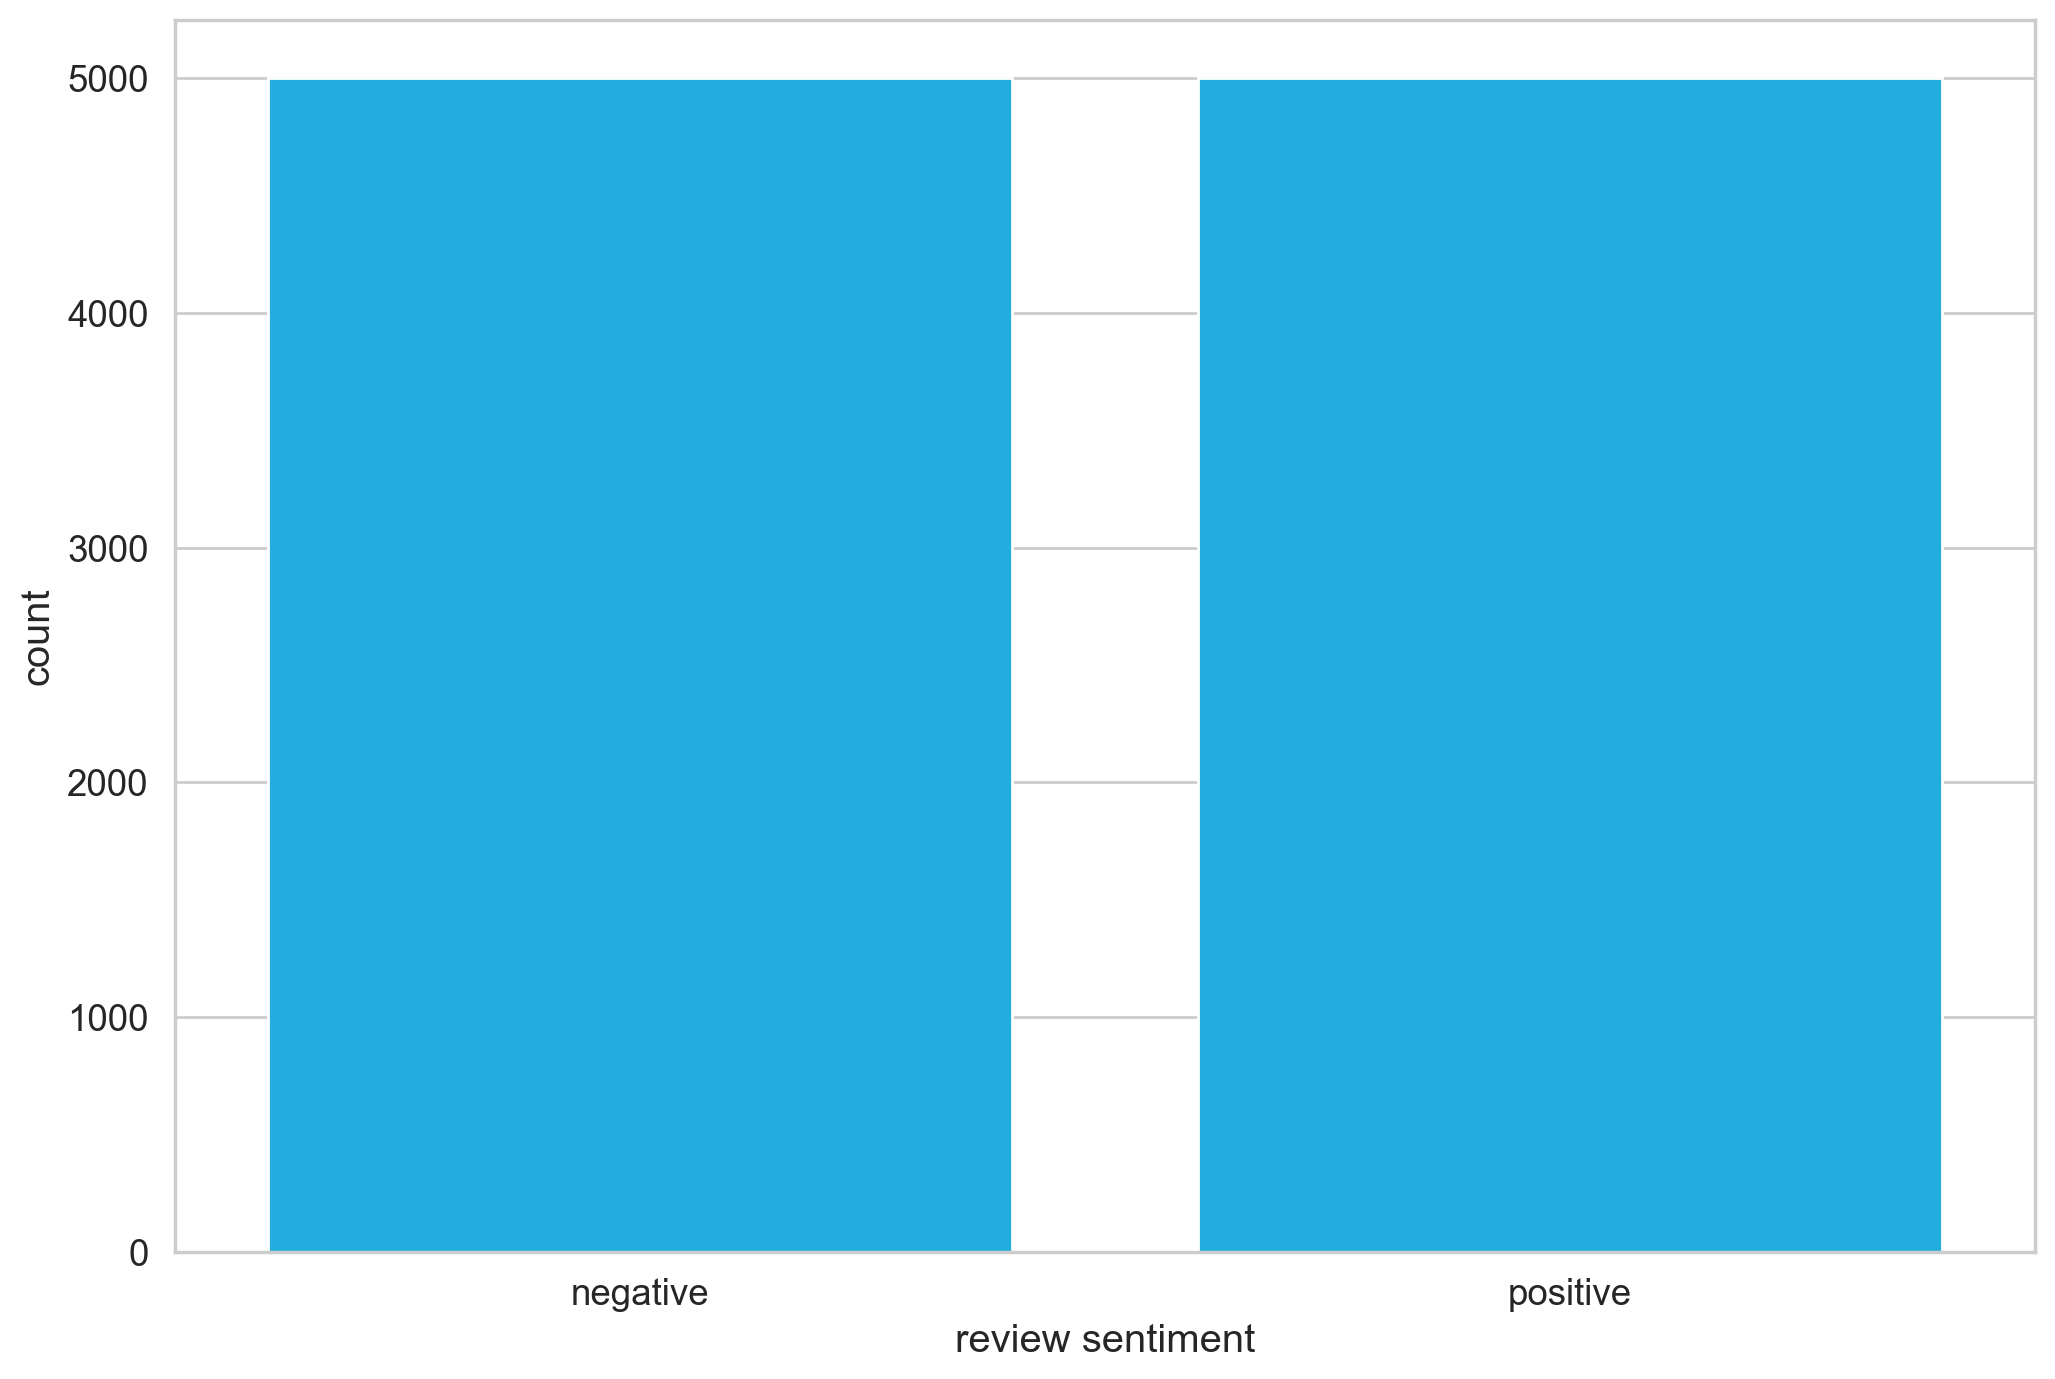

In [9]:
# Plot the distribution
class_names = ['negative', 'positive']
ax = sns.countplot(x=df['sentiment'])
plt.xlabel('review sentiment')
ax.set_xticklabels(class_names)

### Loading the BERT Tokenizer

- `MODEL_NAME` specifies the pretrained BERT variant we will use (`bert-base-cased`).  
- The tokenizer converts raw tweet text into tokens and input IDs that BERT can understand.  
- Using the pretrained tokenizer ensures consistency with the BERT model’s vocabulary and encoding scheme.

In [10]:
MODEL_NAME = 'bert-base-cased'

tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)

### Understanding Common BERT Tokens

BERT uses special tokens to structure input sequences for the model:

- `CLS` (`[CLS]`): Placed at the beginning of each sentence; used by BERT for classification tasks.  
- `SEP` (`[SEP]`): Marks the end of a sentence or separates sentences in paired inputs.  
- `PAD` (`[PAD]`): Used to pad shorter sequences so all inputs in a batch have the same length.  
- `UNK` (`[UNK]`): Represents tokens not found in BERT’s vocabulary.  

Printing these tokens and their IDs helps us verify how text will be encoded before training.

In [11]:
# Some of the common BERT tokens
print(tokenizer.sep_token, tokenizer.sep_token_id) # marker for ending of a sentence
print(tokenizer.cls_token, tokenizer.cls_token_id) # start of each sentence, so BERT knows we’re doing classification
print(tokenizer.pad_token, tokenizer.pad_token_id) # special token for padding
print(tokenizer.unk_token, tokenizer.unk_token_id) # tokens not found in training set

[SEP] 102
[CLS] 101
[PAD] 0
[UNK] 100


### Analyzing Token Lengths

- Each tweet is tokenized using the BERT tokenizer with a maximum length of 512 tokens.  
- The `token_lens` list stores the number of tokens for each tweet.  
- Understanding token lengths helps determine an appropriate `max_length` for padding/truncation during model training, ensuring sequences fit within BERT’s limits.

In [12]:
token_lens = []

for txt in df.text:
    tokens = tokenizer.encode(txt, max_length=512)
    token_lens.append(len(tokens))


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


### Visualizing Token Lengths

- Plot a histogram of token counts to see how long the tweets are after tokenization.  
- Limiting the x-axis to 256 helps focus on the majority of tweets, since very few exceed this length.  
- This visualization informs the choice of `max_length` when preparing inputs for BERT.

Text(0.5, 0, 'Token count')

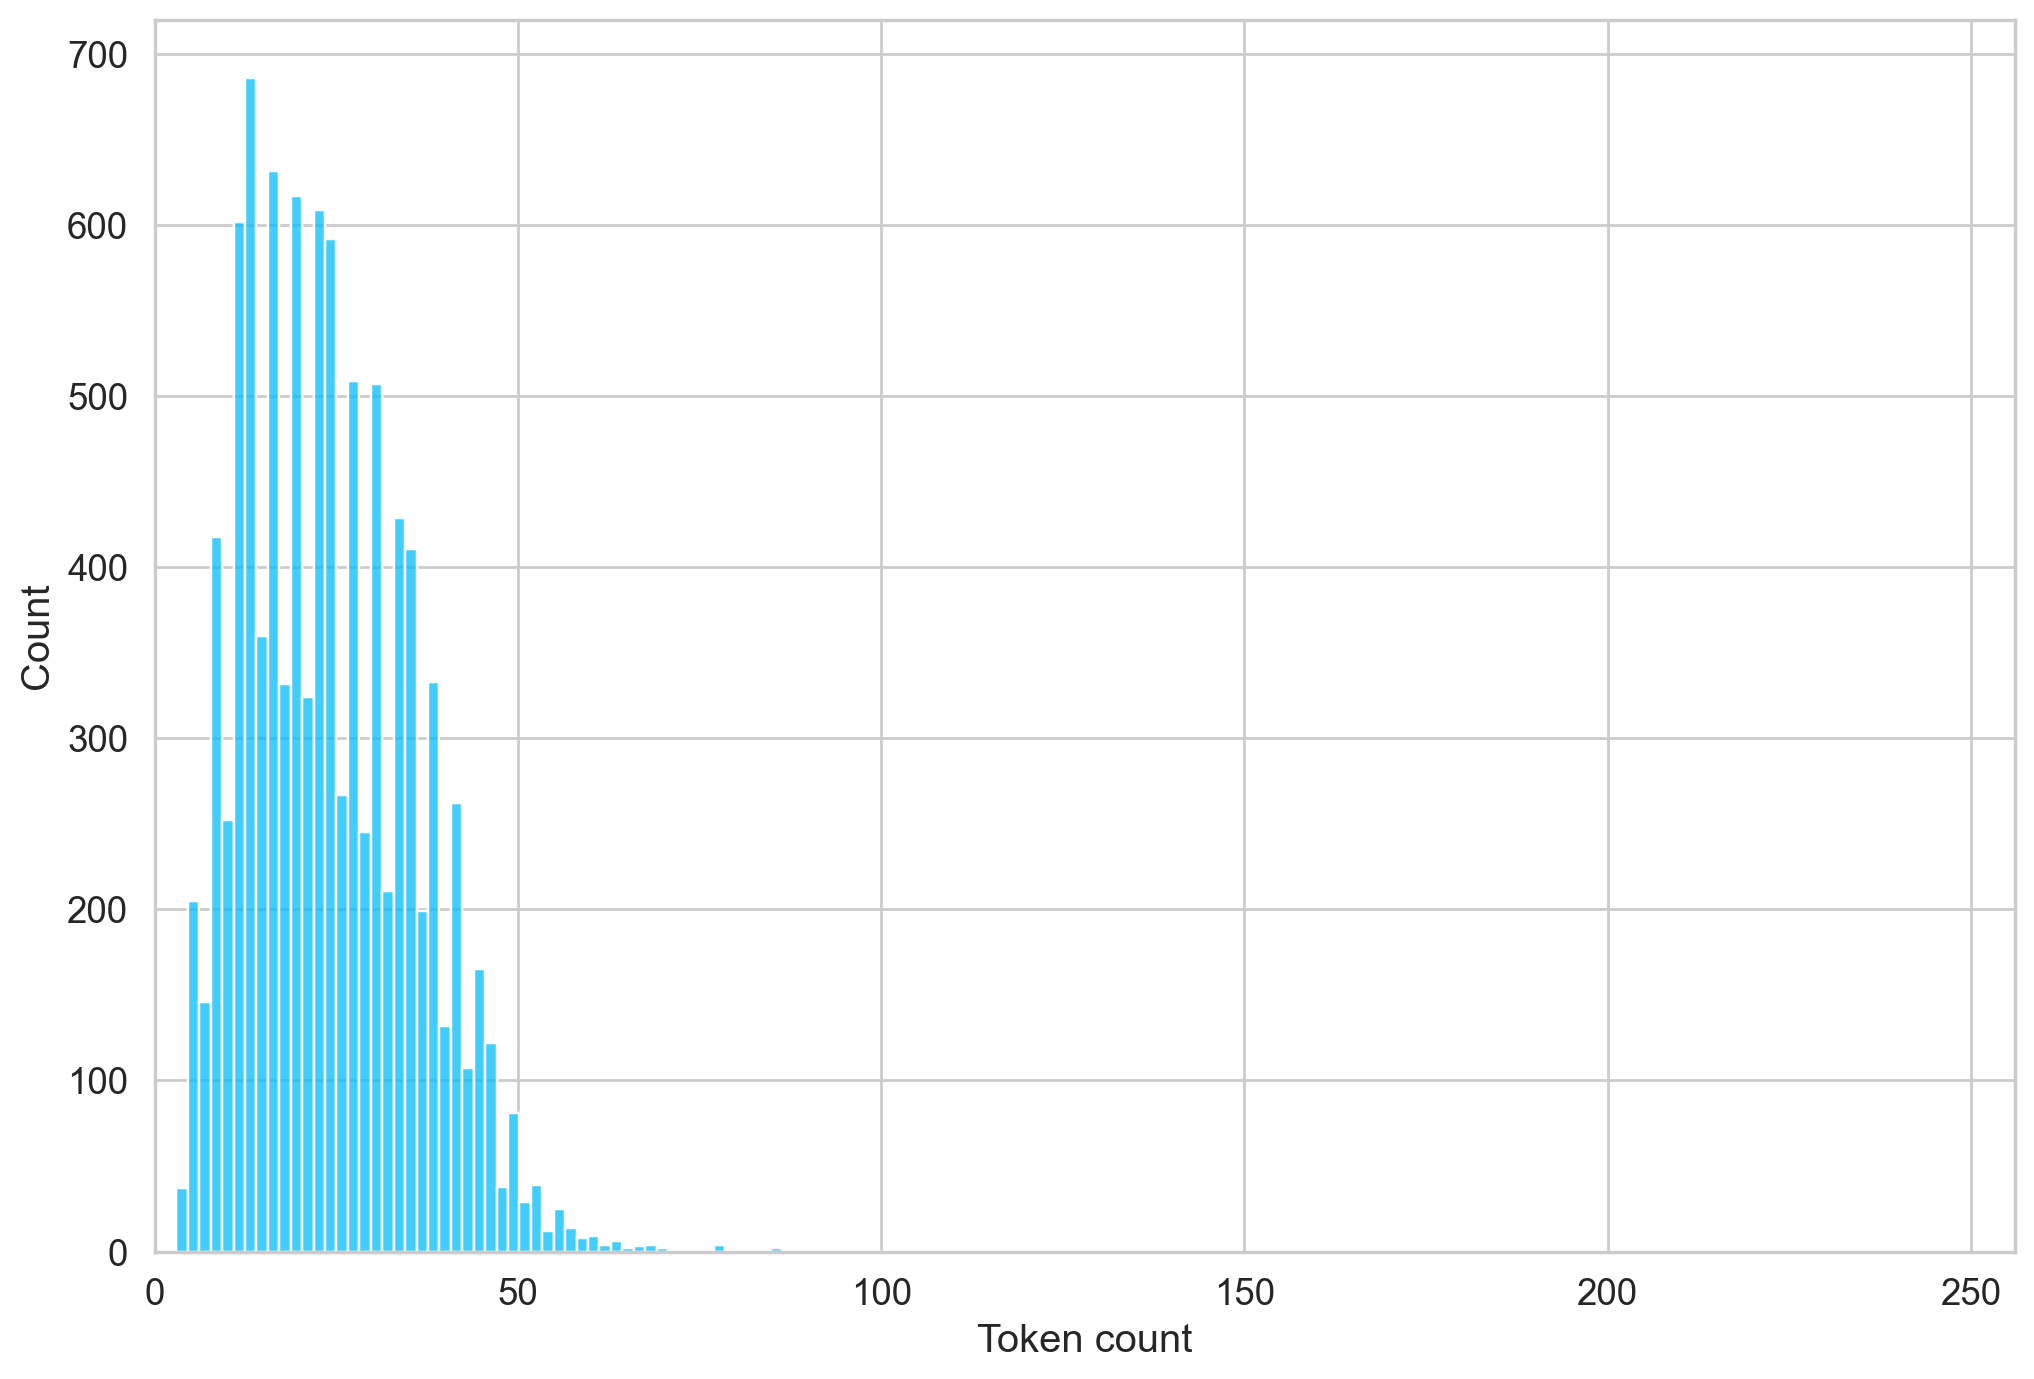

In [13]:
sns.histplot(token_lens)
plt.xlim([0, 256])
plt.xlabel('Token count')

### Setting Maximum Sequence Length

- Based on the token length distribution, `MAX_LEN` is set to 160.  
- Tweets longer than this will be truncated, and shorter ones will be padded.  
- This ensures inputs fit within BERT’s limits while minimizing information loss.

In [14]:
MAX_LEN = 160

### Creating a Custom Dataset Class

- `GPReviewDataset` is a PyTorch `Dataset` for handling tweet text and labels.  
- Responsibilities of this class:  
  - Store reviews and their corresponding sentiment labels.  
  - Tokenize each review using the BERT tokenizer with a fixed `max_len`.  
  - Return a dictionary containing:  
    - `review_text`: original text  
    - `input_ids`: token IDs for BERT input  
    - `attention_mask`: indicates which tokens are padding vs actual content  
    - `targets`: the sentiment label as a tensor  

- This structure allows easy batching and integration with PyTorch’s `DataLoader` for model training and evaluation.

In [15]:
class GPReviewDataset(Dataset):
    def __init__(self, reviews, targets, tokenizer, max_len):
        self.reviews = reviews
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.reviews)

    def __getitem__(self, item):
        review = str(self.reviews[item])
        target = self.targets[item]

        encoding = self.tokenizer.encode_plus(
            review,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )

        return {
            'review_text': review,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'targets': torch.tensor(target, dtype=torch.long)
        }

### Splitting the Dataset

- The dataset is split into **training, validation, and test sets**.  
- `train_test_split` with `stratify` ensures that each subset maintains the same proportion of positive and negative tweets.  

**Process:**  
1. First, 20% of the data is held out as a temporary set (`df_temp`), leaving 80% for training.  
2. Then, `df_temp` is split evenly to create validation and test sets (10% each of the total data).  
3. Printing the value counts confirms that all splits maintain class balance.  

- This stratified splitting helps prevent bias and ensures the model is evaluated fairly across all classes.

In [16]:
from sklearn.model_selection import train_test_split

# Stratified splitting to ensure all classes appear in every set
df_train, df_temp = train_test_split(
    df,
    test_size=0.2,
    random_state=RANDOM_SEED,
    stratify=df['sentiment']       # ensures all classes are proportionally represented
)

df_val, df_test = train_test_split(
    df_temp,
    test_size=0.5,
    random_state=RANDOM_SEED,
    stratify=df_temp['sentiment']  # ensures all classes are proportionally represented
)

print(df_train['sentiment'].value_counts())
print(df_val['sentiment'].value_counts())
print(df_test['sentiment'].value_counts())


# df_train, df_test = train_test_split(df, test_size=0.2, random_state=RANDOM_SEED)
# df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=RANDOM_SEED)

# print(df_train.shape, df_val.shape, df_test.shape)

sentiment
0    4000
1    4000
Name: count, dtype: int64
sentiment
1    500
0    500
Name: count, dtype: int64
sentiment
1    500
0    500
Name: count, dtype: int64


### Creating DataLoaders

- Define a helper function `create_data_loader` to convert a DataFrame into a PyTorch `DataLoader`.  
- Steps performed:  
  1. Instantiate the `GPReviewDataset` with reviews, sentiment labels, tokenizer, and `max_len`.  
  2. Wrap the dataset in a `DataLoader` to handle batching during training and evaluation.  

- `batch_size` controls how many samples are processed together in each iteration.  
- `num_workers=0` ensures compatibility in environments like Google Colab.

In [17]:
def create_data_loader(df, tokenizer, max_len, batch_size):
    ds = GPReviewDataset(
        reviews=df.text.to_numpy(),
        targets=df.sentiment.to_numpy(),
        tokenizer=tokenizer,
        max_len=max_len
    )

    return DataLoader(
        ds,
        batch_size=batch_size,
        num_workers=0
    )

### Preparing DataLoaders for Training and Evaluation

- Set the `BATCH_SIZE` to 16 for training and evaluation.  
- Create `DataLoader` objects for the training, validation, and test sets using the previously defined helper function.  
- These DataLoaders will efficiently provide batches of tokenized inputs and labels to the BERT model during training and evaluation.

In [18]:
BATCH_SIZE = 16
train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

### Inspecting a Batch from the DataLoader

- Retrieve one batch from the training DataLoader to verify its structure.  
- `data.keys()` shows the items returned by the dataset:  
  - `input_ids`: token IDs for BERT input  
  - `attention_mask`: distinguishes padding tokens from actual content  
  - `targets`: sentiment labels  
- Printing the shapes confirms that the batch size and sequence length match expectations.

In [19]:
# Examples
data = next(iter(train_data_loader))
print(data.keys())

print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

dict_keys(['review_text', 'input_ids', 'attention_mask', 'targets'])
torch.Size([16, 160])
torch.Size([16, 160])
torch.Size([16])


### Loading the Pretrained BERT Model

- Load the pretrained BERT model (`bert-base-cased`) from Hugging Face.  
- This model provides contextual embeddings for input tokens and will be fine-tuned for sentiment classification.  
- At this stage, the model has pretrained weights learned from large corpora, but no task-specific training yet.

In [20]:
bert_model = BertModel.from_pretrained(MODEL_NAME)

### Defining the Sentiment Classifier

- `SentimentClassifier` is a custom PyTorch model built on top of BERT for sentiment analysis.  
- Components of the model:  
  1. **BERT backbone:** Provides contextual embeddings for input tokens.  
  2. **Dropout layer:** Applies 30% dropout to reduce overfitting.  
  3. **Linear output layer:** Maps BERT’s pooled output to `n_classes` (2 in this case: negative and positive).  

- `forward` method:  
  - Passes `input_ids` and `attention_mask` through BERT.  
  - Extracts the `pooler_output` ([CLS] token embedding) as a sentence-level representation.  
  - Applies dropout and outputs logits for classification.

In [21]:
class SentimentClassifier(nn.Module):

    def __init__(self, n_classes):
        super(SentimentClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(MODEL_NAME)
        self.drop = nn.Dropout(p=0.3)
        self.out = nn.Linear(self.bert.config.hidden_size, n_classes)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        pooled_output = outputs.pooler_output
        output = self.drop(pooled_output)
        return self.out(output)

### Initializing the Model

- Instantiate the `SentimentClassifier` with the number of classes (`len(class_names)` = 2).  
- Move the model to the appropriate device (`CPU` or `GPU`) for training and evaluation.  
- At this stage, the model is ready to receive input batches from the DataLoaders.

In [22]:
model = SentimentClassifier(len(class_names))
model = model.to(device)

### Inspecting BERT’s Hidden Size

- `bert_model.config.hidden_size` shows the dimensionality of BERT’s pooled output.  
- This value determines the input size for the classifier’s linear layer and is typically 768 for `bert-base` models.  
- Knowing this ensures the classifier layer is correctly sized to accept BERT embeddings.

In [23]:
print(bert_model.config.hidden_size)

768


### Setting Up Training Components

- **EPOCHS:** The number of times the model will iterate over the entire training dataset (set to 10).  
- **Optimizer:** `AdamW` is used to update model weights with weight decay regularization, commonly used with BERT.  
- **Learning Rate Scheduler:** `get_linear_schedule_with_warmup` gradually increases the learning rate at the start (warmup) and then decays it linearly over training.  
- **Loss Function:** `CrossEntropyLoss` is used for multi-class classification (binary in this case).  
- All components are moved to the appropriate device (`CPU` or `GPU`) for computation.

In [24]:
EPOCHS = 10

optimizer = AdamW(model.parameters(), lr=2e-5)

total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

### Training for One Epoch

- `train_epoch` performs a single pass through the training dataset.  
- Steps for each batch:  
  1. Move `input_ids`, `attention_mask`, and `targets` to the device.  
  2. Reset gradients with `optimizer.zero_grad()`.  
  3. Forward pass: compute model outputs.  
  4. Compute predictions and calculate the loss using `CrossEntropyLoss`.  
  5. Backward pass: compute gradients.  
  6. Gradient clipping (`max_norm=1.0`) to prevent exploding gradients.  
  7. Update model weights (`optimizer.step()`) and adjust learning rate (`scheduler.step()`).  
- Returns:  
  - Training accuracy (correct predictions / total examples)  
  - Average training loss for the epoch

In [25]:
def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
    model = model.train()
    losses = []
    correct_predictions = 0

    for d in data_loader:
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        targets = d["targets"].to(device)

        optimizer.zero_grad()

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )

        _, preds = torch.max(outputs, dim=1)
        loss = loss_fn(outputs, targets)
        correct_predictions += torch.sum(preds == targets)
        losses.append(loss.item())

        loss.backward()


        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()


    return correct_predictions.double() / n_examples, np.mean(losses)

### Evaluating the Model

- `eval_model` performs a forward pass over the validation or test dataset without updating model weights.  
- Steps for each batch:  
  1. Move inputs and targets to the device.  
  2. Compute model outputs using `torch.no_grad()` to save memory and computation.  
  3. Calculate predictions and compute the loss.  
  4. Accumulate correct predictions and losses.  
- Returns:  
  - Accuracy over the dataset  
  - Average loss  
- This function is used to monitor the model’s performance and detect overfitting.

In [26]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
    model = model.eval()

    losses = []
    correct_predictions = 0

    with torch.no_grad():
        for d in data_loader:
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )

            _, preds = torch.max(outputs, dim=1)
            loss = loss_fn(outputs, targets)

            correct_predictions += torch.sum(preds == targets)
            losses.append(loss.item())

        return correct_predictions.double() / n_examples, np.mean(losses)

### Training the Model

- Run the model for the specified number of `EPOCHS`.  
- For each epoch:  
  1. Train on the training set using `train_epoch`, recording loss and accuracy.  
  2. Evaluate on the validation set using `eval_model`, recording loss and accuracy.  
  3. Append metrics to the `history` dictionary for later visualization.  
  4. Save the model’s state if the validation accuracy improves (`best_model_state.bin`).  

- `%%time` measures how long the training loop takes.  
- This loop monitors performance on both training and validation sets to track learning and detect overfitting.

In [30]:
%%time

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

    print(f"Epoch {epoch + 1}/{EPOCHS}")
    print("-"*10)

    train_acc, train_loss = train_epoch(
        model,
        train_data_loader,
        loss_fn,
        optimizer,
        device,
        scheduler,
        len(df_train)
    )

    print(f"Train loss {train_loss} accuracy {train_acc}")


    val_acc, val_loss = eval_model(
        model,
        val_data_loader,
        loss_fn,
        device,
        len(df_val)
    )

    print(f"Val loss {val_loss} accuracy {val_acc}")
    print()

    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val-loss'].append(val_loss)


    if val_acc > best_accuracy:
        torch.save(model.state_dict(), 'best_model_state.bin')
        best_accuracy = val_acc

Epoch 1/10
----------
Train loss 0.49168112620711324 accuracy 0.75975
Val loss 0.41239030103361796 accuracy 0.804

Epoch 2/10
----------
Train loss 0.30270200999081137 accuracy 0.88275
Val loss 0.47047599626793746 accuracy 0.819

Epoch 3/10
----------
Train loss 0.17128353303391486 accuracy 0.944125
Val loss 0.9614422761406454 accuracy 0.793

Epoch 4/10
----------
Train loss 0.10760411064513027 accuracy 0.972625
Val loss 1.1847526267880486 accuracy 0.798

Epoch 5/10
----------
Train loss 0.06819861566706095 accuracy 0.98425
Val loss 1.3080472707866677 accuracy 0.798

Epoch 6/10
----------
Train loss 0.04395793221850181 accuracy 0.989375
Val loss 1.3789399507499875 accuracy 0.797

Epoch 7/10
----------
Train loss 0.01788649394186359 accuracy 0.99575
Val loss 1.551299723574803 accuracy 0.799

Epoch 8/10
----------
Train loss 0.015488878489821218 accuracy 0.996625
Val loss 1.5354135283860304 accuracy 0.809

Epoch 9/10
----------
Train loss 0.0073522733717181835 accuracy 0.9985
Val loss 1.

### Plotting Training and Validation Accuracy

- Visualize how the model’s accuracy changes over epochs.  
- `history['train_acc']` and `history['val_acc']` track training and validation accuracy, respectively.  
- The plot helps identify trends such as:  
  - Improvement in learning  
  - Overfitting if validation accuracy stagnates or decreases while training accuracy continues to rise.  
- The y-axis is limited to focus on the accuracy range.

(0.0, 2.0)

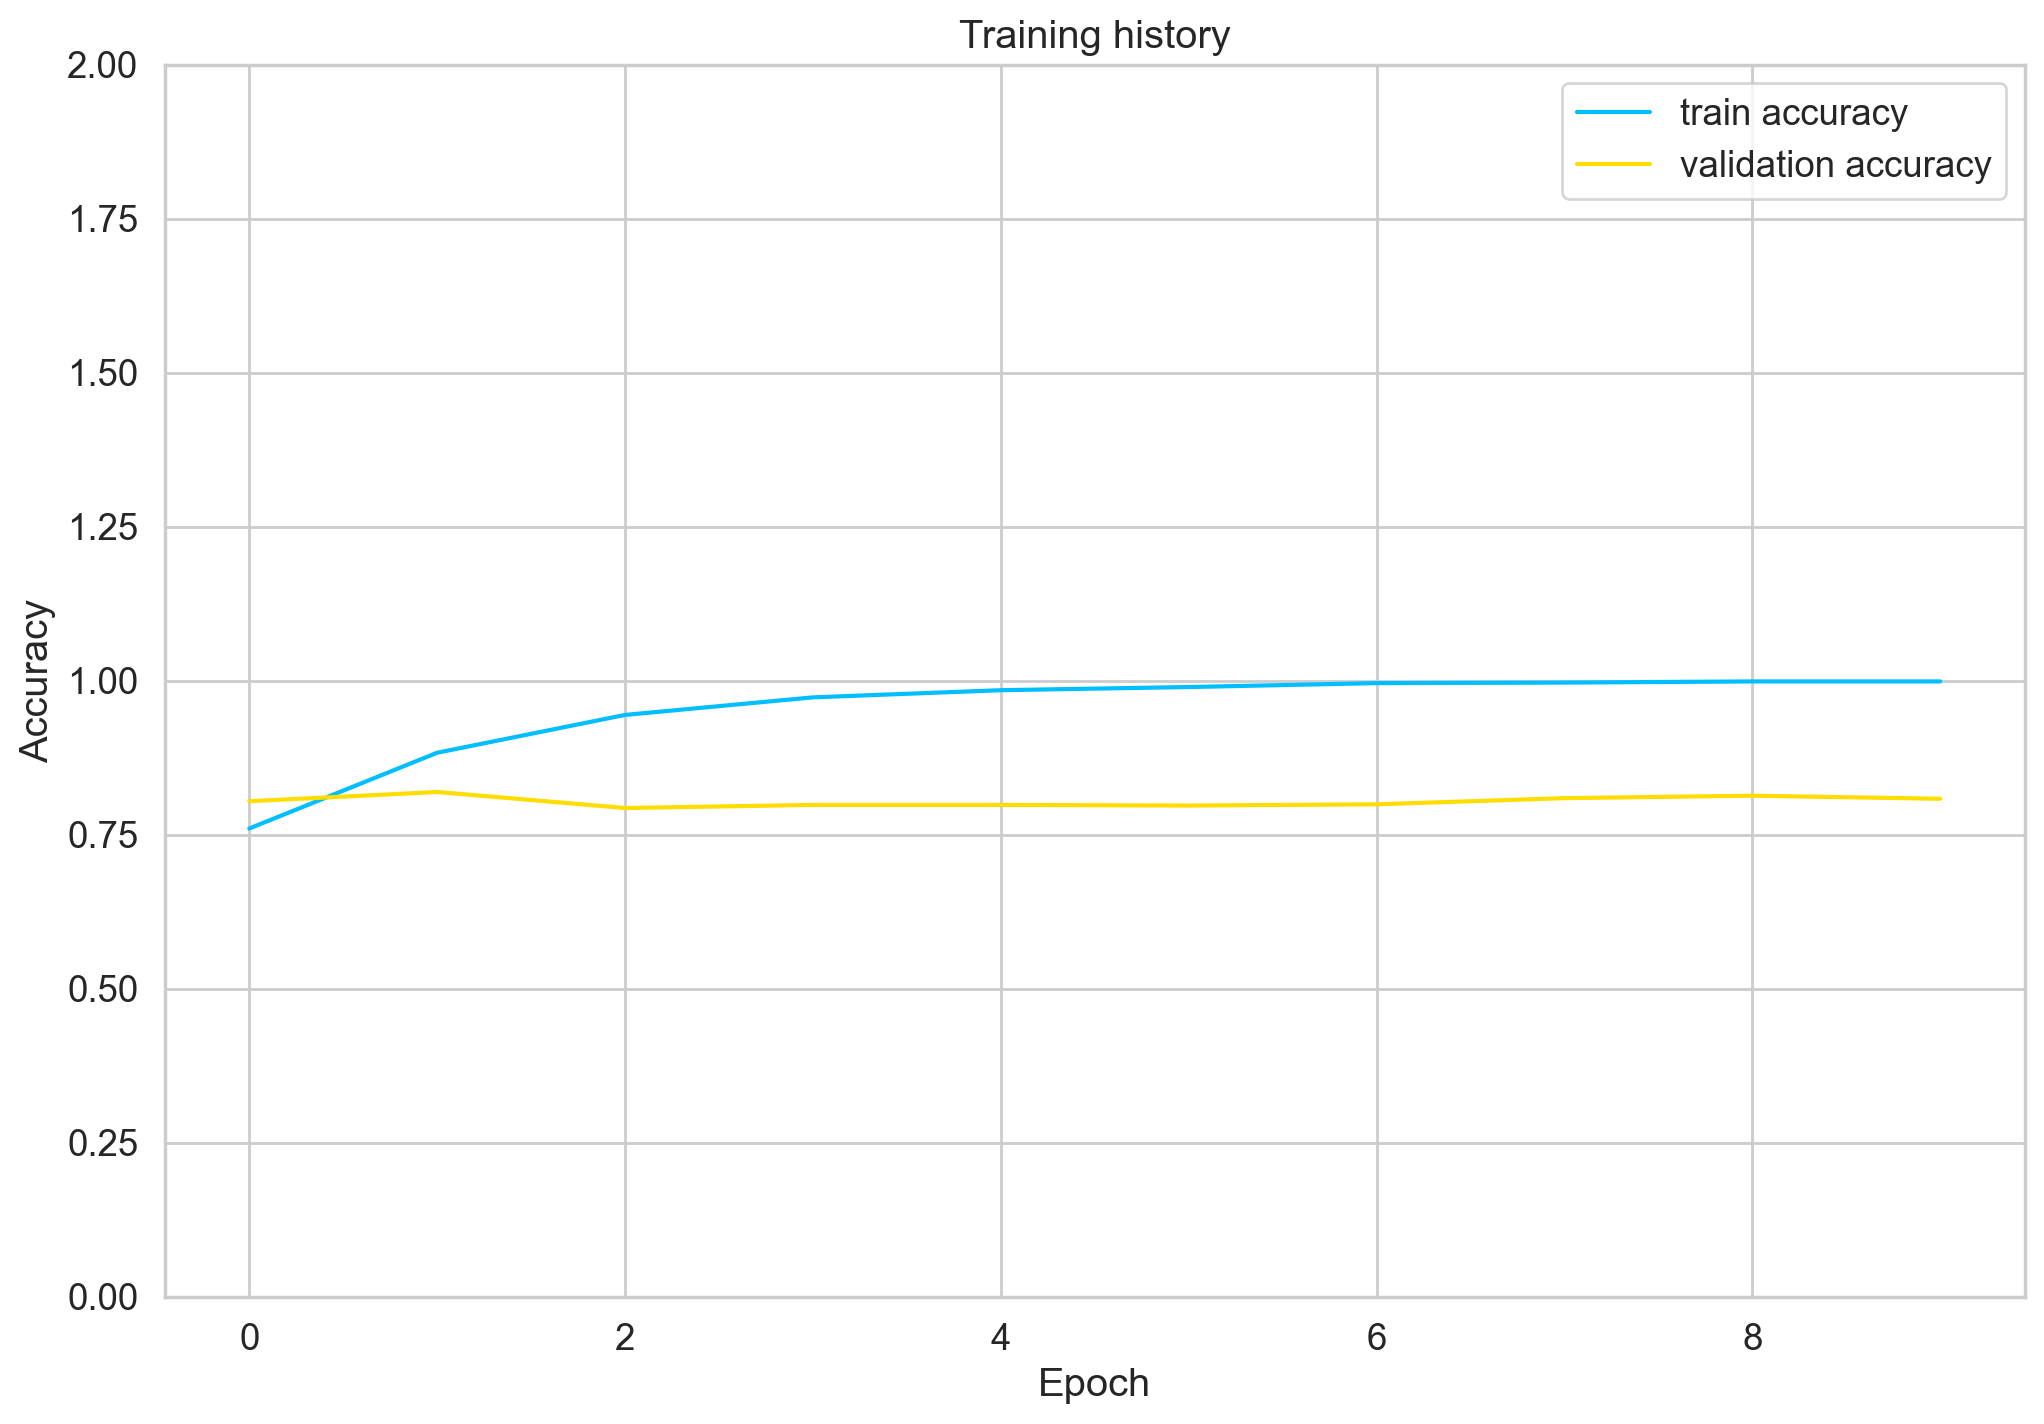

In [31]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 2])

### Evaluating on the Test Set

- After training, evaluate the model on the **unseen test set** to measure its generalization performance.  
- `eval_model` returns the accuracy and average loss on the test data.  
- `test_acc.item()` extracts the accuracy value as a standard Python number for reporting.

In [32]:
test_acc, _ = eval_model(
    model,
    test_data_loader,
    loss_fn,
    device,
    len(df_test)
)

test_acc.item()

0.802

### Generating Predictions

- `get_predictions` is a helper function to obtain model outputs for a given dataset.  
- Steps:  
  1. Set the model to evaluation mode with `model.eval()`.  
  2. Loop through the DataLoader without computing gradients (`torch.no_grad()`).  
  3. For each batch:  
     - Extract review text, token IDs, attention masks, and targets.  
     - Pass inputs through the model to get output logits.  
     - Determine predicted classes with `torch.max`.  
  4. Collect the original texts, predicted labels, raw output probabilities, and true labels.  
- Converts tensors to CPU for further analysis and evaluation.

In [33]:
def get_predictions(model, data_loader):
    model = model.eval()

    review_texts = []
    predictions = []
    prediction_probs = []
    real_values = []

    with torch.no_grad():
        for d in data_loader:
            texts = d["review_text"]
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)

            outputs = model(
                input_ids = input_ids,
                attention_mask = attention_mask
            )

            _, preds =torch.max(outputs, dim=1)

            review_texts.extend(texts)
            predictions.extend(preds)
            prediction_probs.extend(outputs)
            real_values.extend(targets)

        predictions = torch.stack(predictions).cpu()
        prediction_probs = torch.stack(prediction_probs).cpu()
        real_values = torch.stack(real_values).cpu()

        return review_texts, predictions, prediction_probs, real_values

### Getting Predictions on the Test Set

- Use the `get_predictions` function to obtain:  
  - `y_review_texts`: original tweet texts  
  - `y_pred`: predicted sentiment labels  
  - `y_pred_probs`: raw output probabilities from the model  
  - `y_test`: true sentiment labels  
- These outputs can be used for further evaluation, analysis, and visualization of model performance.

In [34]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
    model,
    test_data_loader
)

### Checking Unique Classes in Test Labels

- Display the unique sentiment classes present in the test set (`y_test`).  
- This helps confirm that both negative (0) and positive (1) classes are represented for evaluation.

In [35]:
print("Unique classes in y_test:", np.unique(y_test))

Unique classes in y_test: [0 1]


### Classification Report

- Use `classification_report` from `sklearn` to evaluate model performance on the test set.  
- Provides precision, recall, F1-score, and support for each class (`negative` and `positive`).  
- This detailed report helps understand how well the model predicts each sentiment category.

In [36]:
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

    negative       0.81      0.79      0.80       500
    positive       0.79      0.81      0.80       500

    accuracy                           0.80      1000
   macro avg       0.80      0.80      0.80      1000
weighted avg       0.80      0.80      0.80      1000



### Confusion Matrix

- The confusion matrix visualizes the model’s performance by showing counts of:  
  - True positives and true negatives (correct predictions)  
  - False positives and false negatives (misclassifications)  
- Using a heatmap makes it easier to interpret where the model is performing well and where it struggles.  
- Rows represent the **true sentiment**, and columns represent the **predicted sentiment**.

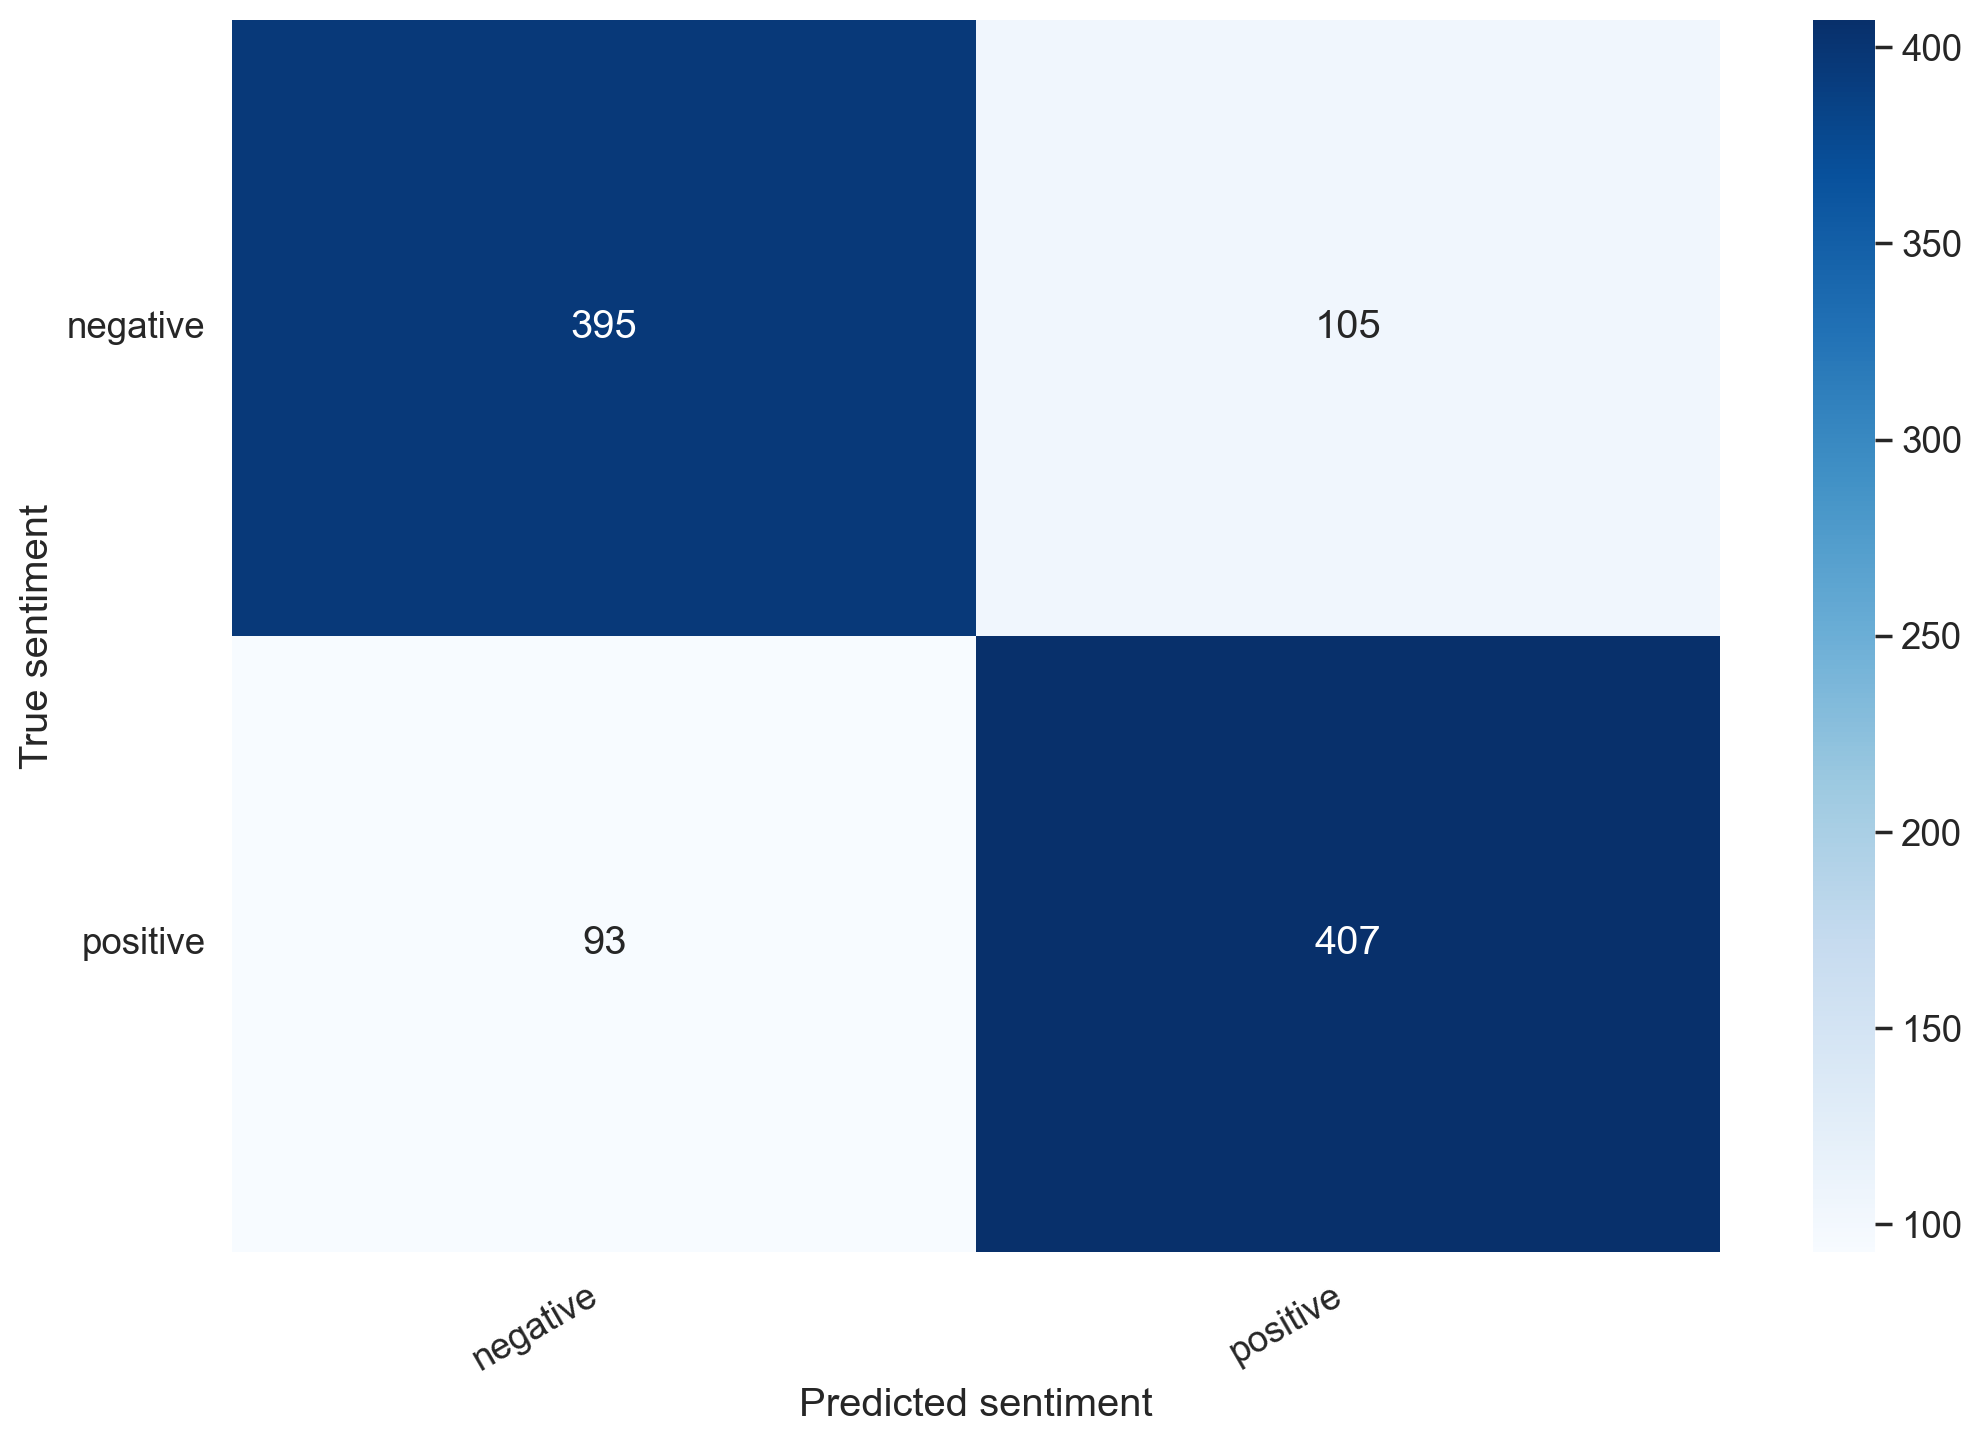

In [37]:
def show_confusion_matrix(confusion_matrix):
    hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
    hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
    hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
    plt.ylabel('True sentiment')
    plt.xlabel('Predicted sentiment')


cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)